In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
torch.cuda.is_available()

True

In [3]:
training_data = datasets.FashionMNIST(
    root = './data',
    train = True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [4]:
batch_size = 64

# Daata Loaders

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for x, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [12]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

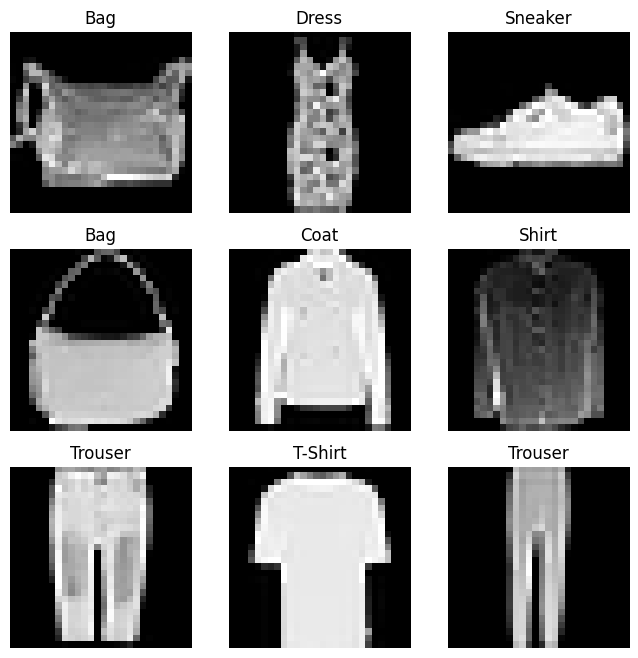

In [13]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
# Get Gpu or Cpu device for training

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


In [6]:
# Define Model
class NeuralNetwork(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.flatten = nn.Flatten()
        
        self.liner_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.liner_relu_stack(x)
        return logits

In [7]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (liner_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [14]:
x = torch.rand(1, 28, 28, device=device)
logits = model(x)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted Class: {y_pred}")

Predicted Class: tensor([6], device='cuda:0')


In [8]:
# Define perameters of loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size=len(dataloader.dataset)
    model.train()

    for batch, (x,y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute Prediction Erro
        pred =  model(x)
        loss = loss_fn(pred, y)

        # BACKPROAGATION
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch+1) * len(x)
            print(f"Loss: {loss:>7f}  [{current:>5d} / {size:>5d}]")

In [18]:
# def test(dataloader, model, loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     model.eval()
#     test_loss, correct = 0

#     with torch.no_grad():
#         for x, y in dataloader:
#             x, y = x.to(device), y.to(device)
#             pred = model(x)
#             test_loss += loss_fn(pred, y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
#     test_loss /= num_batches
#     correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg Loss: {test_loss:>8f}\n")



In [22]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [23]:
epochs = 10

for i in range(epochs):
    print(f"Epoch {i+1}\n----------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Training Finished!")

Epoch 1
----------------------------------
Loss: 1.329010  [   64 / 60000]
Loss: 1.315607  [ 6464 / 60000]
Loss: 1.143937  [12864 / 60000]
Loss: 1.251128  [19264 / 60000]
Loss: 1.125235  [25664 / 60000]
Loss: 1.150216  [32064 / 60000]
Loss: 1.189766  [38464 / 60000]
Loss: 1.110926  [44864 / 60000]
Loss: 1.145402  [51264 / 60000]
Loss: 1.075483  [57664 / 60000]
Test Error: 
 Accuracy: 65.0%, Avg loss: 1.090415 

Epoch 2
----------------------------------
Loss: 1.158693  [   64 / 60000]
Loss: 1.166876  [ 6464 / 60000]
Loss: 0.981666  [12864 / 60000]
Loss: 1.114319  [19264 / 60000]
Loss: 0.985577  [25664 / 60000]
Loss: 1.018101  [32064 / 60000]
Loss: 1.070631  [38464 / 60000]
Loss: 0.997854  [44864 / 60000]
Loss: 1.030564  [51264 / 60000]
Loss: 0.975477  [57664 / 60000]
Test Error: 
 Accuracy: 65.9%, Avg loss: 0.984871 

Epoch 3
----------------------------------
Loss: 1.039342  [   64 / 60000]
Loss: 1.069236  [ 6464 / 60000]
Loss: 0.869392  [12864 / 60000]
Loss: 1.021967  [19264 / 60000]

In [24]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [25]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [26]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [27]:
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
